# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [24]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from tqdm                    import tqdm


def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [ ]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3

test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [34]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40439828823725865
RMSE when predicting testing data:
1.0667260022550893
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [35]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [36]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851357650711806


In [37]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384599, -1.08513577])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [38]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

___

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [39]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

#### **Answer**

The graph shows how the RMSE of the random forest model changes as it is trained on progressively larger portions of the dataset. To generate this, the code splits the training data into 20 evenly spaced segments. For each segment size, the model is trained on the first x rows and evaluated on the same test set. As the size of the training data increases, the RMSE decreases, indicating that the model performs better with more data. 

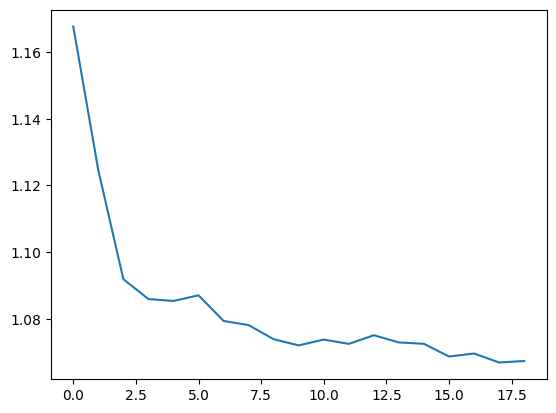

In [41]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

____

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [42]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

In [43]:
X, y = make_X_y(alpha=0.5)

In [44]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9
0,0.622717,-0.480707,1.037668,0.561202,1.692105,-1.169791,0.634249,-0.012359,0.127773,-0.292650
1,-2.258633,-0.101289,-1.615413,-0.300907,-0.079662,0.789549,-0.518908,-1.083084,-0.338635,-0.446288
2,0.977498,-0.542809,0.402769,-1.872118,0.114102,-0.670701,3.157280,-1.272158,0.412567,-0.626862
3,0.284378,-0.827582,-2.894831,0.734812,-0.513164,0.765196,-1.614126,-0.497806,-0.006778,0.519268
4,2.452391,-2.297030,0.027158,-1.752596,0.412703,-0.794950,-0.064028,-0.217500,-1.660472,0.826157
...,...,...,...,...,...,...,...,...,...,...
9995,-1.067422,-0.003373,-0.374867,-0.354563,-2.182605,-2.483084,-0.969791,-1.248143,-0.861268,1.033518
9996,-0.497754,1.438425,0.188309,-0.795225,0.161312,0.891236,-0.351417,0.212189,-0.000951,0.750802
9997,-0.178017,-0.621996,0.028617,0.621417,-0.117994,0.185826,1.067237,0.740362,0.945737,-1.261278
9998,0.997185,0.304854,-0.907328,1.445031,-0.223297,-2.124878,1.999501,-0.475945,1.106641,-0.074290


In [45]:
y = pd.DataFrame(y)
y

,0
0,2.371949
1,0.275149
2,1.265497
3,-1.401599
4,-0.958122
...,...
9995,0.404759
9996,-0.119225
9997,1.319490
9998,-0.688440


- The above code creates an X with ten columns, corresponding to ten different stocks.  
- The y is the eleventh stock.  

The stocks have some commonalities: 
- The even numbered stocks are related, as are the odds.  
- The stocks that are multiples of three are all related, too.  

Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.



____

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10? **Under 'my prediction' below** Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.



**My Prediction**

I predict that alpha=10 will be the best prediction. From the description so far, we know that an alpha = 0 is essentially just noise, while an alpha=10 will result in strong relationships between the stocks. With stronger relationships *between* the stocks, the model will be able to pick up on this and subsequently perform better. 

In [46]:
# Make Data
X_alpha0, y_alpha0 = make_X_y(alpha=0)
X_alpha10, y_alpha10 = make_X_y(alpha=10)

# Train Test Split
X0_train, X0_test, y0_train, y0_test = train_test_split(X_alpha0, y_alpha0, test_size=0.2, random_state=42)
X10_train, X10_test, y10_train, y10_test = train_test_split(X_alpha10, y_alpha10, test_size=0.2, random_state=42)

# RF for Alpha 0
rf_alpha0 = RandomForestRegressor()
rf_alpha0.fit(X0_train, y0_train)
rf_alpha0_preds = rf_alpha0.predict(X0_test)
alpha_0_performance = root_mean_squared_error(rf_alpha0_preds, y0_test)

# RF for Alpha 10 
rf_alpha10 = RandomForestRegressor()
rf_alpha10.fit(X10_train, y10_train)
rf_alpha10_preds = rf_alpha10.predict(X10_test)
alpha_10_performance = root_mean_squared_error(rf_alpha10_preds, y10_test)

# RMSE
alpha_0_rmse = root_mean_squared_error(rf_alpha0_preds, y0_test)
alpha_10_rmse = root_mean_squared_error(rf_alpha10_preds, y10_test)

# Correlation
alpha_0_corr = np.corrcoef(rf_alpha0_preds, y0_test)[0, 1]
alpha_10_corr = np.corrcoef(rf_alpha10_preds, y10_test)[0, 1]

# R^2 Score
alpha_0_r2 = r2_score(y0_test, rf_alpha0_preds)
alpha_10_r2 = r2_score(y10_test, rf_alpha10_preds)

print(f"Alpha 0 RMSE: {alpha_0_rmse}")
print(f"Alpha 10 RMSE: {alpha_10_rmse}\n")
print(f"Alpha 0 Correlation: {alpha_0_corr}")
print(f"Alpha 10 Correlation: {alpha_10_corr}\n")
print(f"Alpha 0 R^2: {alpha_0_r2}")
print(f"Alpha 10 R^2: {alpha_10_r2}")

Alpha 0 RMSE: 1.0000644472420788
Alpha 10 RMSE: 1.2205587697180376

Alpha 0 Correlation: 0.016560597409754796
Alpha 10 Correlation: 0.992340629255767

Alpha 0 R^2: -0.022266303523756692
Alpha 10 R^2: 0.9847389374180415


**Conclusion After Testing Alpha = 0 and Alpha = 10**

When we ran the RMSE calculation for models trained on alpha = 0 and alpha = 10 datasets, the model trained on alpha = 0 data had a lower RMSE. This was surprising, because alpha = 0 should produce data that’s essentially just noise, while alpha = 10 introduces strong underlying relationships — and we would expect the model to perform better in that case.

However, once we incorporated additional metrics like correlation and R², it became clear that the model trained on alpha = 10 was far superior in terms of generalization. The correlation between predicted and actual values was nearly zero in the alpha = 0 case (~-0.01), but jumped to ~0.99 (almost perfect) in the alpha = 10 model. Likewise, the R² score went from -0.03 (worse than random guessing) with alpha = 0 to 0.98 with alpha = 10, confirming that the model captured the underlying signal extremely well.

Overall, this highlights the importance of using more than just RMSE metrics to test our model performance, especially when it comes to comparing model performance with different *dataset* variances as well. 

___

# Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

**Answer**

I took time to research the balanced_accuracy_score. I did this because I’m exploring evaluation metrics that will be relevant to my own dataset for the upcoming final project proposal, which is due in just a few weeks.

In my case, the research question focuses on injury rates and whether certain variables can help predict those injuries. One of the biggest challenges I’ve run into is class imbalance: injury rates in my datasets are often around 2% or even lower. For this reason, I believe the balanced accuracy metric will be especially useful.

Balanced accuracy works by averaging the sensitivity (recall) for each class. In my case, that means one value for correctly predicted positives (injuries), and one for correctly predicted negatives (non-injuries). This is important because a classifier that simply predicts “non-injured” for every example could still achieve around 98% accuracy with standard metrics — despite completely failing to detect injuries. Balanced accuracy corrects for this by ensuring that performance on the minority class (injuries) is fairly evaluated.

**New Dataset for Classification and Unbalanced Target**

In [21]:
dt1 = np.random.random(size=10000) * 3
dt2 = np.random.random(size=10000) * 3
dt3 = np.random.random(size=10000) * 3

df_target = ((dt1 + dt2) / dt3 **2)

my_df  = pd.DataFrame({'f1': dt1, 'f2': dt2, 'f3': dt3, 'target': df_target})
my_df['new_target'] = np.where(my_df['target'] > 75, 1, 0)
my_df.drop(columns='target', axis=1, inplace=True)

**Train Test Split**

In [22]:
X_val = my_df.drop(columns='new_target')
y_val = my_df['new_target']

XTrain, XTest, yTrain, yTest = train_test_split(X_val, y_val, test_size=0.2, random_state=42)


**Random Search CV Using the balanced_accuracy**

In [ ]:


# Assign train/test sets
X_train = XTrain
X_test = XTest
y_train = yTrain
y_test = yTest

random_state = 42
start = time.time()

# Define the model
forest_model = RandomForestClassifier(random_state=random_state)

# Define the parameter distributions
param_dist = {
    'n_estimators': [10, 33, 100, 150, 200],
    'max_depth': [None] + list(range(3, 20, 2)),
    'max_leaf_nodes': [None] + list(range(5, 100, 10))
}

# Set up cross-validation strategy
rcv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=forest_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='balanced_accuracy',
    cv=rcv,
    n_jobs=-1,
    random_state=random_state,
    return_train_score=True
)

# Fit the model
search.fit(X_train, y_train)

# Predict on test set
y_pred_rf = search.best_estimator_.predict(X_test)

# Extract results
results = pd.DataFrame(search.cv_results_)

# Select and clean relevant columns
results = results[[
    'param_n_estimators',
    'param_max_depth',
    'param_max_leaf_nodes',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',
    'std_train_score',
    'rank_test_score'
]]

# Sort results by performance
results = results.sort_values(by='rank_test_score')

# Rename columns for clarity
renamed_results = results.rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_max_depth': 'max_depth',
    'param_max_leaf_nodes': 'max_leaf_nodes',
    'mean_test_score': 'mean_cv_score',
    'std_test_score': 'std_cv_score',
    'mean_train_score': 'mean_train_score',
    'std_train_score': 'std_train_score'
}).drop(columns=['rank_test_score'])

# Print top results
print("\nRandomizedSearch Results (Top 10):\n")
print(renamed_results.head(10).to_string(index=False))

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV Balanced Accuracy: {search.best_score_:.4f}")

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# End timer
end = time.time()

# Optional: format time output nicely
def format_time(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {secs:.1f}s"

print(f"Execution Time: {format_time(end - start)}")


RandomizedSearch Results (Top 10):

 n_estimators max_depth max_leaf_nodes  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          100        13             95       0.980444      0.009542          1.000000         0.000000
          100        19             65       0.980187      0.009179          1.000000         0.000000
          150        13             65       0.980090      0.009568          1.000000         0.000000
          150        11           None       0.979234      0.010769          1.000000         0.000000
          200        13             55       0.978623      0.009237          1.000000         0.000000
          100        19             45       0.978622      0.009407          0.999612         0.000689
          150        17             45       0.978526      0.010181          0.999454         0.000735
           10        17             75       0.976783      0.011424          0.998398         0.001645
           10         9           No

**Ran again with the original data (And a regressor model)**

In [52]:

X_train = train_df
X_test = test_df

y_train = train_target
y_test = test_target

random_state=42
start = time.time()

# Define the model
forest_model = RandomForestRegressor(random_state=random_state)

# Define the parameter distributions
param_dist = {
    'n_estimators': [10, 33, 100, 150, 200],        # Add more values if you want
    'max_depth': [None] + list(range(3, 20, 2)),
    'max_leaf_nodes': [None] + list(range(5, 100, 10))
}

# Set up cross-validation strategy
rcv = RepeatedKFold(random_state=42)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=forest_model,
    param_distributions=param_dist,
    n_iter=25,  # Increase this if you want more combinations tested
    scoring='neg_mean_squared_error',
    cv=rcv,
    n_jobs=-1,
    random_state=random_state,
    return_train_score=True
)

# Fit the model
search.fit(X_train, y_train)

# Extract results
results = pd.DataFrame(search.cv_results_)

# Select and clean relevant columns
results = results[[
    'param_n_estimators',
    'param_max_depth',
    'param_max_leaf_nodes',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',
    'std_train_score',
    'rank_test_score'
]]

results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

results = results.sort_values(by='rank_test_score')

# Rename for clarity
renamed_results = results.rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_max_depth': 'max_depth',
    'param_max_leaf_nodes': 'max_leaf_nodes',
    'mean_test_score': 'mean_cv_score',
    'std_test_score': 'std_cv_score',
    'mean_train_score': 'mean_train_score',
    'std_train_score': 'std_train_score'
}).drop(columns=['rank_test_score'])

# Print top results
print("\nRandomizedSearch Results (Top 10):\n")
print(renamed_results.head(10).to_string(index=False))

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")
print(f"Best RMSE: {math.sqrt(-search.best_score_):.4f}")

# Evaluate on test set
y_pred_rf = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_rf)
print(f"Test MSE:    {test_mse:.4f}")

# End timer
end = time.time()
print(f"Execution Time: " + format_time(end-start))


RandomizedSearch Results (Top 10):

 n_estimators max_depth max_leaf_nodes  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          150        11           None       1.130536      0.031816          0.409475         0.003992
           10         9           None       1.149598      0.033438          0.701960         0.006516
          100         7           None       1.184586      0.035540          0.960073         0.008023
          100        13             95       1.184687      0.034352          0.986714         0.007312
          150         7             95       1.197273      0.035358          0.999832         0.007566
          150        13             65       1.267369      0.039039          1.094656         0.008423
          100        19             65       1.268655      0.039000          1.095976         0.009309
           10        17             75       1.271996      0.041103          1.085763         0.009417
          200        13             

____

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

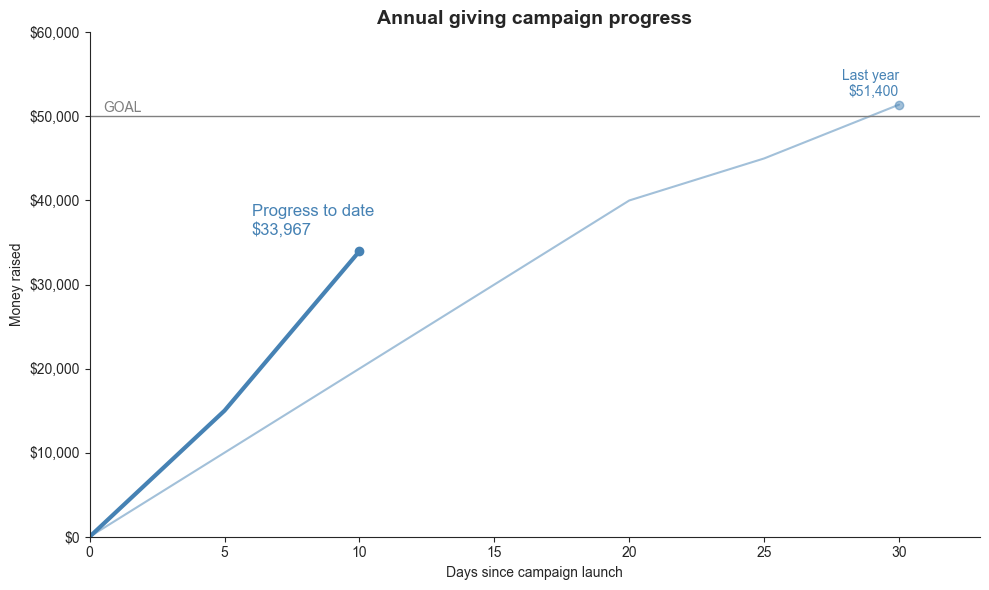

In [ ]:
last_year_data = {
    0: 0, 
    5: 10_000, 
    10: 20_000,
    15: 30_000,
    20: 40_000,
    25: 45_000,
    30: 51_400
}

this_year_data = {
    0: 0, 
    5: 15_000, 
    10: 33_967
}

# Convert to DataFrames
last_year_df = pd.DataFrame(list(last_year_data.items()), columns=['Days', 'Last Year'])
this_year_df = pd.DataFrame(list(this_year_data.items()), columns=['Days', 'This Year'])

# Plot
plt.figure(figsize=(10, 6))

# Plot last year
plt.plot(last_year_df['Days'], last_year_df['Last Year'], label='Last year', color='steelblue', alpha=0.5)
plt.plot(this_year_df['Days'], this_year_df['This Year'], label='Progress to date', color='steelblue', linewidth=3)

# Add goal line
plt.axhline(50000, color='gray', linestyle='-', linewidth=1)
plt.text(0.5, 50500, 'GOAL', color='gray', fontsize=10)

# Highlight last point of this year
latest_day = this_year_df['Days'].max()
latest_value = this_year_df[this_year_df['Days'] == latest_day]['This Year'].values[0]
plt.scatter(latest_day, latest_value, color='steelblue')
plt.text(latest_day - 4, latest_value + 2000, f'Progress to date\n${latest_value:,.0f}', fontsize=12, color='steelblue')

# Label final value from last year
plt.scatter(30, 51400, color='steelblue', alpha=0.5)
plt.text(30, 51400 + 1000, 'Last year\n$51,400', fontsize=10, color='steelblue', ha='right')

# Axis formatting
plt.title("Annual giving campaign progress", fontsize=14, weight='bold')
plt.xlabel("Days since campaign launch")
plt.ylabel("Money raised")
plt.ylim(0, 60000)
plt.xlim(0, 33)
plt.xticks(range(0, 35, 5))
plt.yticks(range(0, 70000, 10000), [f"${x:,.0f}" for x in range(0, 70000, 10000)])

# Remove top and right spines
sns.set_style("ticks")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()